# AGC + calver coffea on coffea-casa

We'll base this on a few sources:
- https://github.com/iris-hep/analysis-grand-challenge/tree/main/analyses/cms-open-data-ttbar (AGC, of course)
- https://github.com/alexander-held/CompHEP-2023-AGC (contains a simplified version of AGC)
- https://github.com/nsmith-/TTGamma_LongExercise/ (credit Nick Smith for helpful examples of the new API)
- (and if time allows, weight features: https://github.com/CoffeaTeam/coffea/blob/backports-v0.7.x/binder/accumulators.ipynb / https://coffeateam.github.io/coffea/api/coffea.analysis_tools.Weights.html#coffea.analysis_tools.Weights.partial_weight)

In [1]:
from pathlib import Path
import matplotlib.pyplot as plt

import awkward as ak
import dask
import dask_awkward as dak
import hist.dask
import coffea
import numpy as np
import uproot
import traceback
from dask.distributed import Client
import skhep_testdata
import pandas as pd

from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.analysis_tools import PackedSelection
from coffea import dataset_tools

import warnings

import utils
utils.plotting.set_style()

warnings.filterwarnings("ignore")
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here


client = Client("tls://localhost:8786")

print(f"awkward: {ak.__version__}")
print(f"dask-awkward: {dak.__version__}")
print(f"dask: {dask.__version__}")
print(f"uproot: {uproot.__version__}")
print(f"hist: {hist.__version__}")
print(f"coffea: {coffea.__version__}")

/usr/local/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


awkward: 2.6.7
dask-awkward: 2024.7.0
dask: 2024.8.1
uproot: 5.3.11.dev61+ga214027
hist: 2.7.3
coffea: 2024.8.1


### Produce an AGC histogram with Dask (no coffea yet)

In [2]:
def calculate_trijet_mass(events):
    # pT > 30 GeV for leptons, > 25 GeV for jets
    selected_electrons = events.Electron[events.Electron.pt > 30 & (np.abs(events.Electron.eta) < 2.1)]
    print("Selected electrons: ", selected_electrons)
    selected_muons = events.Muon[events.Muon.pt > 30 & (np.abs(events.Muon.eta) < 2.1)]
    selected_jets = events.Jet[events.Jet.pt > 25 & (np.abs(events.Jet.eta) < 2.4)]

    # single lepton requirement
    event_filters = ((ak.count(selected_electrons.pt, axis=1) + ak.count(selected_muons.pt, axis=1)) == 1)
    # at least four jets
    event_filters = event_filters & (ak.count(selected_jets.pt, axis=1) >= 4)
    # at least two b-tagged jets ("tag" means score above threshold)
    B_TAG_THRESHOLD = 0.5
    event_filters = event_filters & (ak.sum(selected_jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)

    # apply filters
    selected_jets = selected_jets[event_filters]

    trijet = ak.combinations(selected_jets, 3, fields=["j1", "j2", "j3"])  # trijet candidate
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system

    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2, np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in trijet candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    return ak.flatten(trijet_mass)

Reading in the ROOT file, we can now create a Dask task graph for the calculations and plot that we want to make using `dask-awkward` and `hist.dask`

In [3]:
all_files = []
events_list = []

# Some files are downloaded locally:
# all_files.append(ttbar_file)
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root") # ttbar remote 533M size
# all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/rntuple/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # RNTuple remote
all_files.append("root://eospublic.cern.ch//eos/root-eos/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-amcatnlo-pythia8/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # TTree remote
all_files.append("/home/cms-jovyan/my_root_files/rntuple_v4.root") # RNTuple, local, with our own converter v4 


# all_files.append("/home/cms-jovyan/my_root_files/ttree/cmsopendata2015_ttbar_19981_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext4-v1_80000_0007.root") # TTree ttbar original
# all_files.append("/home/cms-jovyan/my_root_files/ttree/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root") # TTree local
# all_files.append("/home/cms-jovyan/my_root_files/rntuple/cmsopendata2015_ttbar_19978_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext1-v1_60000_0004.root")  # RNTuple local



def load_files_with_uproot(files):
    for fl in files:
        with uproot.open(fl) as f:
            events = f["Events"]
            events_list.append(events)
            print("File was loaded with uproot, event count: ", len(events.keys()))
            
            # NOTE: to access array: # events.arrays(["Electron_pt"])["Electron_pt"]
        
def load_files_with_coffea(files):
    for fl in files:
        events = NanoEventsFactory.from_root({fl: "Events"}, schemaclass=NanoAODSchema).events()
        events_list.append(events)
        print("File was loaded with coffea, fields count: ", len(events.fields))
        
        
load_files_with_uproot(all_files)

# load_files_with_coffea(all_files)



    



File was loaded with uproot, event count:  947
File was loaded with uproot, event count:  947


In [4]:
print("Starting cell...")

# file = all_files[1]

events_tt = events_list[0]
events_rn = events_list[1]



# # Various available properties:
# print("Name: ", events.name)
# print("header: ", events.header)
# print("footer: ", events.footer)
# print("num_entries: ", events.num_entries)
# print("len of field_names: ", len(events.field_names))
# print("keys: ", len(events.keys()))

# print(" field_names: ", events.fields)


# print("column_records: ", events.column_records[:10])
# print("keys: ", events.keys()[:10])
# print("_column_records_dict: ", events._column_records_dict)
# print("_related_ids: ", events._related_ids)
# print("page_list_envelopes: ", events.page_list_envelopes)


# # Experimenting with array access:
# array = events.arrays(filter_names=["Electron_pt", "Electron_eta"])[:20]
# print("events.arrays(): ", events.arrays())
# print("----------")
# print("events.arrays().show(): ", events.arrays().show())
# print("----------")
# # tree = uproot.open(file)



# Must be sorted, because otherwise the order is different.
keys_tt = sorted(events_tt.keys(), key=str.lower)
keys_rn = sorted(events_rn._keys, key=str.lower)

print(f"TTree keys length: {len(keys_tt)}. RNTuple keys length: {len(keys_rn)}")
# print("")

def calculate_abs_difference(flat_ls1, flat_ls2):
    # Calculate max(abs(x2-x1)):
    # Ensure the arrays are of the same length
    min_length = min(len(flat_ls1), len(flat_ls2))
    
    # Truncate arrays to the common length
    flat_ls1_same_len = flat_ls1[:min_length]
    flat_ls2_same_len = flat_ls2[:min_length]
    
    # Calculate the absolute differences
    abs_differences = np.abs(np.array(flat_ls1_same_len) - np.array(flat_ls2_same_len))
    
    # Calculate the maximum absolute difference
    max_abs_diff = np.max(abs_differences)
    print(f"Maximum absolute difference for key '{key}': {max_abs_diff}")

def draw_graph_flatten(key, arrays_tt, arrays_rn):
    # Flatten the arrays
    flat_tt = ak.ravel(arrays_tt).to_list()
    flat_rn = ak.ravel(arrays_rn).to_list()
    
    
    print("Len of rn after ravel:", len(ak.ravel(arrays_rn)))
    
    
    
    # # Export mathcing sublists to a CSV file using pandas:
    df = pd.DataFrame({
        'flat_tt': pd.Series(flat_tt),
        'flat_rn': pd.Series(flat_rn)
        # 'tt': matching_sublists_tt,
        # 'rn': matching_sublists_rn
    })
    df.to_csv(f'{key}_flattened.csv')
    
    # Create a range for the x-axis based on the length of the arrays
    x_indices_tt = list(range(len(flat_tt)))
    x_indices_rn = list(range(len(flat_rn)))
    
    
    
    # Plot the scatter plot using the indices as x-values and array elements as y-values
    plt.figure(figsize=(10, 6))
    plt.scatter(x_indices_tt, flat_tt, color='blue', alpha=0.3, label='TTree (original files)')
    plt.scatter(x_indices_rn, flat_rn, color='red', alpha=0.5, label='RNTuple (our converter)', marker="x")
    
    # plt.yscale('log')
    plt.ylim(0, 10)  # y-axis limits from 0 to 50

    
    # Labeling
    plt.title(f"Scatter Plot for Key: {key}")
    plt.xlabel('Index')
    plt.ylabel('Array Elements')
    plt.legend()
    
    # Display the plot
    plt.show()
    
def draw_graph_grouped(key, arrays_tt, arrays_rn):
    # Flatten the arrays
    # flat_tt = ak.ravel(arrays_tt).to_list()
    # flat_rn = ak.ravel(arrays_rn).to_list()
    
    indices_of_matching_sublists = []
    match_results = []
    matching_sublists_tt = []
    matching_sublists_rn = []

    
    for i, sublist_rn in enumerate(arrays_rn):
        indices_of_matching_sublists.append(i)
        try:
            assert (len(arrays_tt[i]) == len(arrays_rn[i]) and all(arrays_tt[i] == arrays_rn[i]))
            match_results.append(1)
            matching_sublists_tt.append(arrays_tt[i])
            matching_sublists_rn.append(arrays_rn[i])

        except:
            # print(f"[{i}]",arrays_tt[i], "---", arrays_rn[i])
            match_results.append(0)
            matching_sublists_tt.append(arrays_tt[i])
            matching_sublists_rn.append(arrays_rn[i])

#     print("TT indices len:", len(x_indices_tt))
#     print("RN indices len:", len(x_indices_rn))
    
#     print("TT flat_tt len:", len(flat_tt))
#     print("RN flat_rn len:", len(flat_rn))

    
    # Plot the scatter plot using the sublist indices as x-values and array elements as y-values
    plt.figure(figsize=(10, 6))
    # plt.scatter(x_indices_tt, flat_tt, color='blue', alpha=0.3, label='TTree (original files)')
    # plt.scatter(x_indices_rn, flat_rn, color='red', alpha=0.5, label='RNTuple (our converter)', marker="x")
    plt.scatter(indices_of_matching_sublists, match_results, s=2, color='green', alpha=0.2, label='RNTuple (our converter)')
    
    # # Export the values to a CSV file using pandas
    # df = pd.DataFrame({
    #     'Index': indices_of_matching_sublists,
    #     'Match Result': match_results
    # })
    # df.to_csv(f'{key}_match_results.csv', index=False)
    
    # # # Export mathcing sublists to a CSV file using pandas:
    # df = pd.DataFrame({
    #     'Match Result': match_results,
    #     'Index': indices_of_matching_sublists,
    #     'tt': matching_sublists_tt,
    #     'rn': matching_sublists_rn
    # })
    # df.to_csv(f'{key}_sublists.csv', index=False)

    
    # plt.xscale('log')
    
    # Labeling
    plt.title(f"Scatter Plot for Key: {key}")
    plt.xlabel('Sublist Index')
    plt.ylabel('Does sublist match')
    plt.legend()
    
    # Display the plot
    plt.show()

def compare_key_lists(ls1, ls2):
    match_count = 0
    mismatch_count = 0
    
    ak_match_count = 0
    ak_mismatch_count = 0
    ak_error_count = 0
    
    count_of_all_tt_elements = 0
    count_of_all_rn_elements = 0
    
    for i in range(len(ls1)):
        if keys_tt[i] == keys_rn[i]:
            key = keys_tt[i]
            match_count+=1
            # print(f"\r{i+1}/{len(ls1)}", f" {keys_tt[i]}", end="") # Progress indication without printing too many lines
            # print(f"{i+1}/{len(ls1)}", f" {keys_tt[i]}: ")
            arrays_tt = events_tt.arrays([key])[key]
            arrays_rn = events_rn.arrays([key])[key]
            
            el_count_tt = len(ak.ravel(arrays_tt))
            el_count_rn = len(ak.ravel(arrays_rn))
            
            
            
            # print(f"TT elements: {count_of_all_tt_elements}")
            # print(f"RN elements: {count_of_all_rn_elements}")

            # Check if arrays are equal:
            try:
                are_equal = ak.all(arrays_tt == arrays_rn)
                if are_equal:
                    ak_match_count += 1
                    print(f"[{key}]", "ak arrays are equal")
                elif not are_equal:
                    count_of_all_tt_elements+=el_count_tt
                    count_of_all_rn_elements+=el_count_rn
                    ak_mismatch_count += 1
                    print(f"[{key}]", "ak comparison MISMATCH")
                    print("tt: ", arrays_tt, f"Type: {ak.type(arrays_tt)}. Count of elements: {el_count_tt}")
                    print("rn: ", arrays_rn, f"Type: {ak.type(arrays_rn)}. Count of elements: {el_count_rn}")
                
                # print("Arrays are equal: ", are_equal)  # Output: True
            except:
                count_of_all_tt_elements+=el_count_tt
                count_of_all_rn_elements+=el_count_rn
                ak_error_count += 1
                print(f"[{key}]", "ak comparison ERROR")
                print("tt: ", arrays_tt, f"Type: {ak.type(arrays_tt)}. Count of elements: {el_count_tt}")
                print("rn: ", arrays_rn, f"Type: {ak.type(arrays_rn)}. Count of elements: {el_count_rn}")
                # draw_graph_grouped(key, arrays_tt, arrays_rn)
                draw_graph_flatten(key, arrays_tt, arrays_rn)
                


        else:
            mismatch_count+=1
            # print("Mismatch: ", keys_tt[i], "---", keys_rn[i])
    print(f"Keys comparison statistics: matched count: {match_count}; mismatch count: {mismatch_count}")
    print(f"ak array comparison statistics: matched count: {ak_match_count}; mismatch count: {ak_mismatch_count}; errors: {ak_error_count}")


# compare_key_lists(keys_tt, keys_rn)




# for key in events: 
#     # branch = events.arrays([key])[key]
#     print(key)


## Things that do not work:
# print("Show(): ", events.show()) # 'Model_ROOT_3a3a_Experimental_3a3a_RNTuple' object has no attribute 'show'
# for key, branch in events.iteritems(): # Does not work with RNTuple. AttributeError: no field named 'iteritems'. However, it does work with TTree.
# for key, branch in events.arrays().iteritems(): # Does not work both with TTree or RNTuple.
# print(list(events.arrays().keys())) # Does not work. No field names keys()


## Analyze why these keys mismatch. NOTE: It might be related to cardinality.
# [HTXS_Higgs_y] ak comparison MISMATCH
# [nCorrT1METJet] ak comparison MISMATCH
# [nElectron] ak comparison MISMATCH
# [nFatJet] ak comparison MISMATCH
# [nFsrPhoton] ak comparison MISMATCH
# [nGenDressedLepton] ak comparison MISMATCH
# [nGenIsolatedPhoton] ak comparison MISMATCH
# [nGenJet] ak comparison MISMATCH
# [nGenJetAK8] ak comparison MISMATCH
# [nGenPart] ak comparison MISMATCH
# [nGenVisTau] ak comparison MISMATCH
# [nJet] ak comparison MISMATCH
# [nLHEPart] ak comparison MISMATCH
# [nLHEPdfWeight] ak comparison MISMATCH
# [nLHEScaleWeight] ak comparison MISMATCH
# [nMuon] ak comparison MISMATCH
# [nOtherPV] ak comparison MISMATCH
# [nPhoton] ak comparison MISMATCH
# [nPSWeight] ak comparison MISMATCH
# [nSoftActivityJet] ak comparison MISMATCH
# [nSV] ak comparison MISMATCH
# [nTau] ak comparison MISMATCH
# [SV_pAngle] ak comparison MISMATCH

# Keys comparison statistics: matched count: 947; mismatch count: 0
# ak array comparison statistics: matched count: 924; mismatch count: 23; errors: 0



Starting cell...
TTree keys length: 947. RNTuple keys length: 947


In [22]:
cluster_starts = [md.num_first_entry for md in events_rn.cluster_summaries][1:] # Skip first, because it is 0.
print("Starts of clusters: ", cluster_starts)
print("")
key = "nCorrT1METJet"



def collect_breaking_points(key):
    step = 4
    for cl_start in cluster_starts:
        for i in range (cl_start-10, cl_start+10, step):
            strt = i
            end = i + step
            arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
            arr_rn = events_rn.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
            
            try:
                assert (len(arr_tt) == len(arr_rn) and ak.all(arr_tt == arr_rn))
                # print("EQUAL:")
                # print(f"TT array: {ak.to_list(arr_tt)}")
                # print(f"RN array: {ak.to_list(arr_rn)}")
            except Exception as e:
                print(f"TT array: {arr_tt}")
                print(f"RN array: {arr_rn}")
                print("Index: ", i, f". Failure limits: {(strt, end)}")
                print("")

collect_breaking_points(key)

print("Finished cell.")

Starts of clusters:  [17224, 44433, 71709, 98997, 126243, 153500, 180739]

[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
TT array: [2, 0, 0, 1]
RN array: [2, 0, 18446744073709510780, 0]
Index:  17222 . Failure limits: (17222, 17226)

[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
TT array: [0, 2, 0, 8]
RN array: [0, 2, 18446744073709487437, 0]
Index:  44431 . Failure limits: (44431, 44435)

[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_byte: 14
[uproot debug] key: column-581-cardinality, dtype_

In [6]:
# print(events_tt.keys(filter_name=["run", "Electron_hoe"]))
# print(events_rn.keys(filter_name=["run", "Electron_hoe"]))
# print(events_rn.keys())

In [11]:
print("Starts of clusters: ", cluster_starts)

strt = 1
end = 180739




key = "HTXS_Higgs_y"
# key = "ChsMET_phi"

# TT: [[], [0.144, 1.68], [0], [0, 0, 0.0903, 0.4], ..., [0.0284], [0.0483], [], []]
# RN: [[], [0.144, 1.68], [0], [0, 0, 0.0903, 0.4], ..., [0.0284], [0.0483], [], []]
# all_keys = events_rn.keys()

arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
arr_rn = events_rn.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]

arr_tt = events_tt.arrays(filter_name=[key])[key]
arr_rn = events_rn.arrays(filter_name=[key])[key]

print("TT:", arr_tt)
print("RN:", arr_rn)

print("Finished cell")

Starts of clusters:  [17224, 44433, 71709, 98997, 126243, 153500, 180739]
[uproot debug] key: column-4, dtype_byte: 17
[uproot debug] key: column-4, dtype_byte: 17
TT: [nan, nan, nan, nan, nan, nan, nan, nan, ..., nan, nan, nan, nan, nan, nan, nan]
RN: [nan, nan, nan, nan, nan, nan, nan, nan, ..., nan, nan, nan, nan, nan, nan, nan]
Finished cell


[uproot debug] key: column-4, dtype_byte: 17
HTXS_Higgs_y TT: [nan, nan, nan, nan, nan, nan, nan, nan, ..., nan, nan, nan, nan, nan, nan, nan]  Len: 180738
HTXS_Higgs_y RN: [nan, nan, nan, nan, nan, nan, nan, nan, ..., nan, nan, nan, nan, nan, nan, nan]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


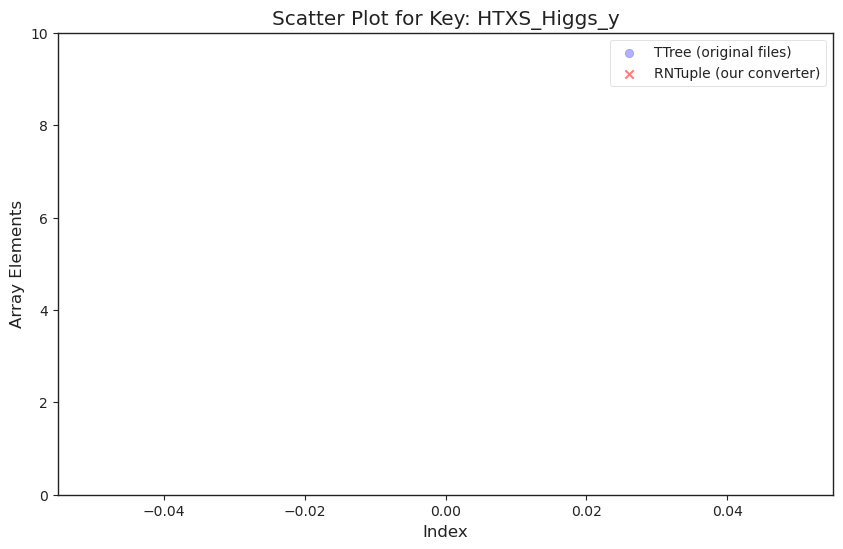

[uproot debug] key: column-581-cardinality, dtype_byte: 14
nCorrT1METJet TT: [4, 2, 1, 1, 3, 2, 2, 3, 1, 2, 3, 0, 4, ..., 4, 8, 1, 3, 3, 1, 3, 1, 2, 1, 3, 6]  Len: 180738
nCorrT1METJet RN: [4, 2, 1, 1, 3, 2, 2, 3, 1, 2, 3, 0, 4, ..., 2, 3, 1, 0, 3, 0, 4, 8, 1, 3, 3, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


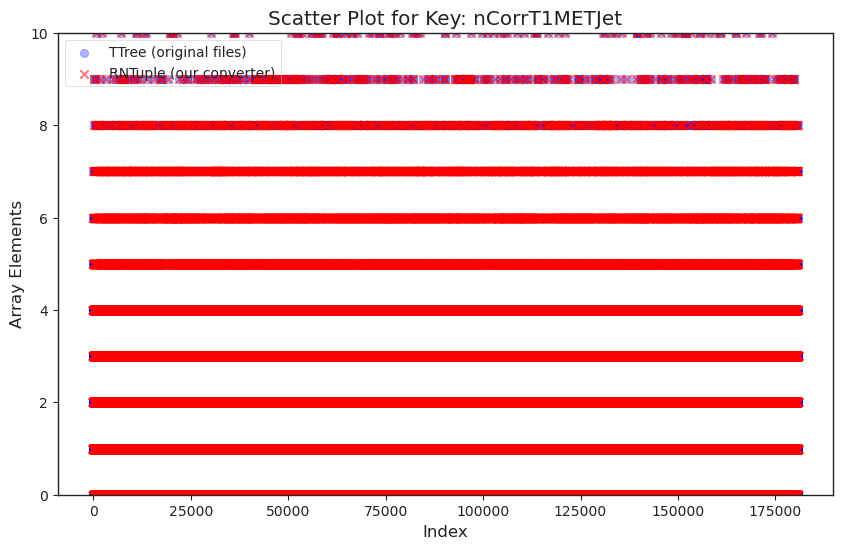

[uproot debug] key: column-587-cardinality, dtype_byte: 14
nElectron TT: [1, 4, 1, 2, 4, 0, 0, 2, 1, 1, 3, 0, 1, ..., 1, 1, 1, 3, 1, 1, 2, 1, 0, 0, 1, 3]  Len: 180738
nElectron RN: [1, 4, 1, 2, 4, 0, 0, 2, 1, 1, 3, 0, 1, ..., 1, 0, 0, 2, 2, 0, 1, 1, 1, 3, 1, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


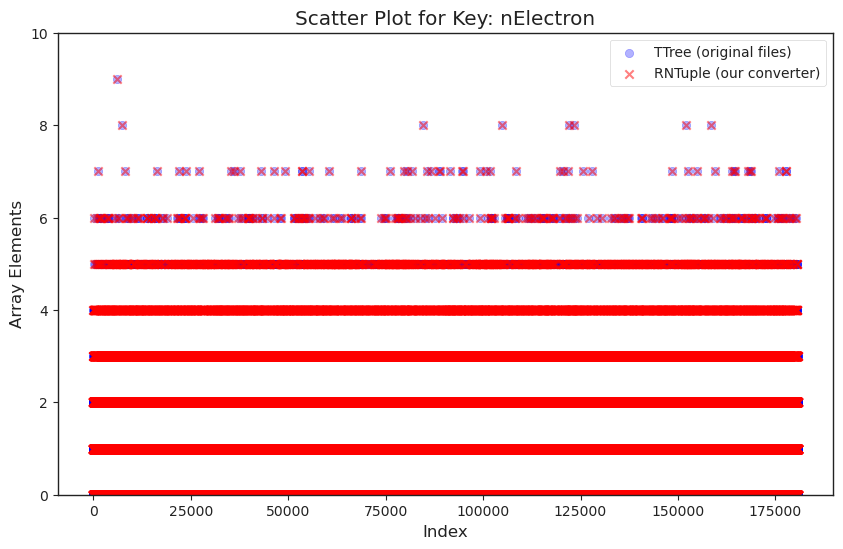

[uproot debug] key: column-641-cardinality, dtype_byte: 14
nFatJet TT: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..., 3, 0, 2, 1, 2, 0, 1, 0, 0, 1, 0, 0]  Len: 180738
nFatJet RN: [0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, ..., 0, 1, 0, 2, 0, 2, 3, 0, 2, 1, 2, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


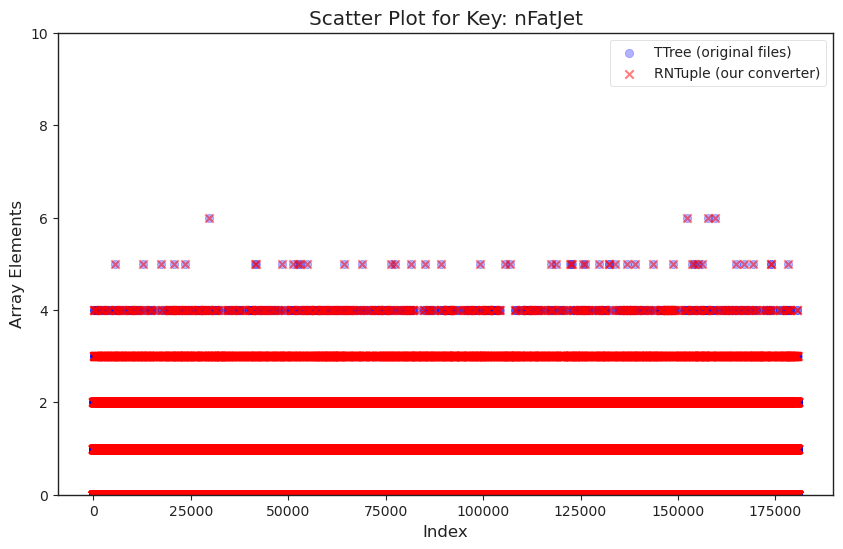

[uproot debug] key: column-694-cardinality, dtype_byte: 14
nFsrPhoton TT: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Len: 180738
nFsrPhoton RN: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


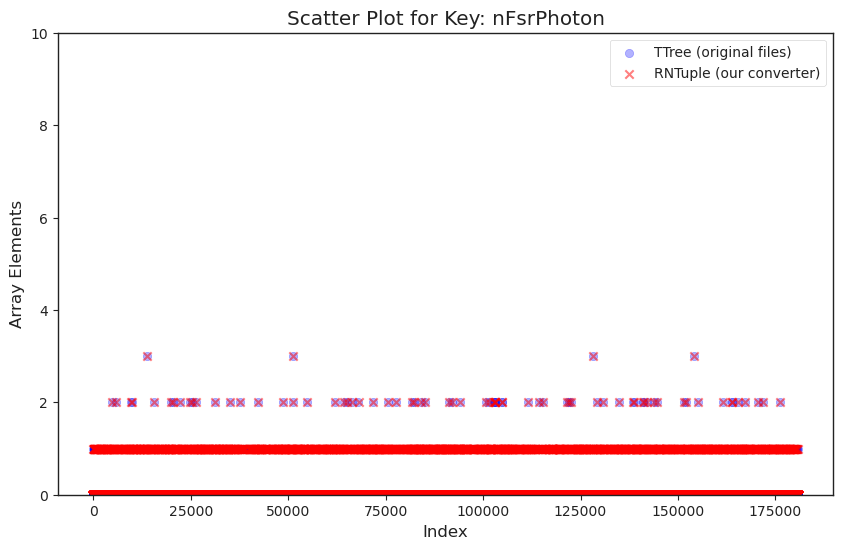

[uproot debug] key: column-701-cardinality, dtype_byte: 14
nGenDressedLepton TT: [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0]  Len: 180738
nGenDressedLepton RN: [1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, ..., 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


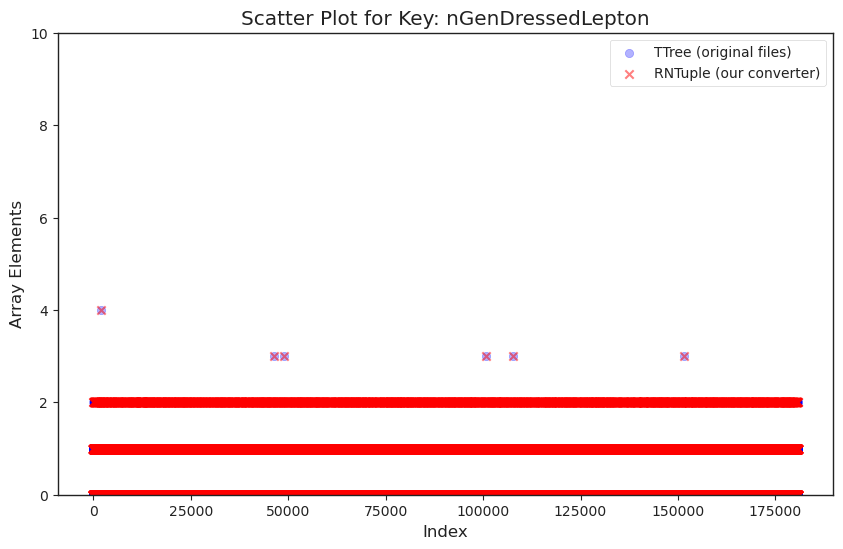

[uproot debug] key: column-708-cardinality, dtype_byte: 14
nGenIsolatedPhoton TT: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Len: 180738
nGenIsolatedPhoton RN: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


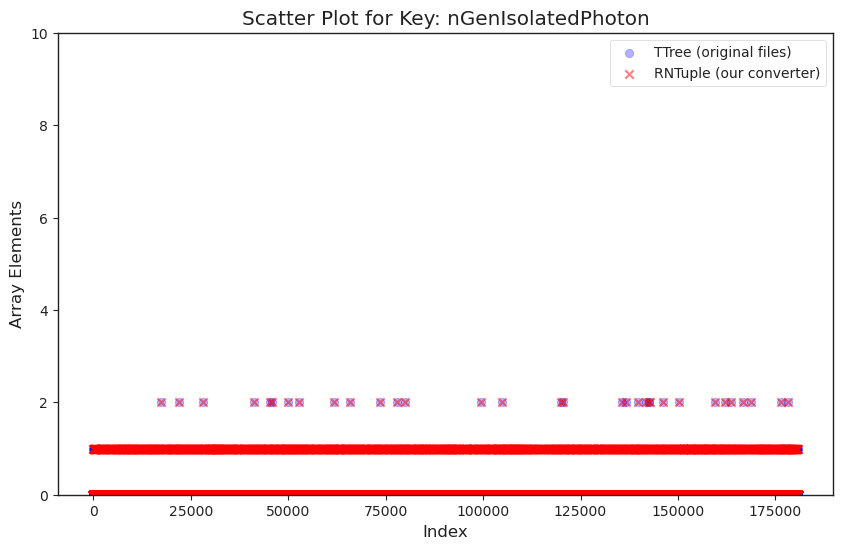

[uproot debug] key: column-713-cardinality, dtype_byte: 14
nGenJet TT: [12, 11, 7, 7, 15, 7, 6, 10, 9, 8, 8, ..., 14, 7, 15, 4, 5, 15, 9, 10, 5, 8, 14]  Len: 180738
nGenJet RN: [12, 11, 7, 7, 15, 7, 6, 10, 9, 8, 8, ..., 11, 7, 8, 9, 8, 7, 14, 7, 15, 4, 5]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


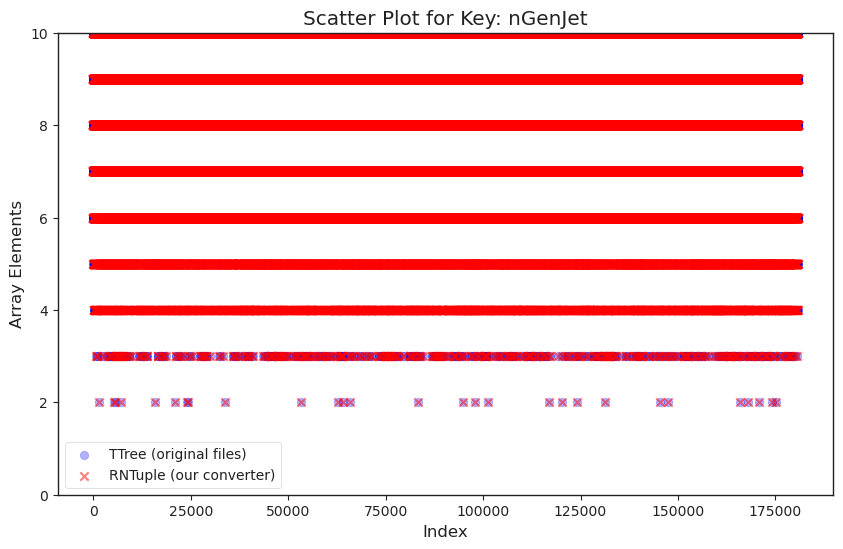

[uproot debug] key: column-720-cardinality, dtype_byte: 14
nGenJetAK8 TT: [0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 1, 0, ..., 3, 2, 2, 2, 2, 0, 1, 1, 0, 2, 0, 0]  Len: 180738
nGenJetAK8 RN: [0, 0, 0, 0, 0, 1, 0, 3, 0, 1, 0, 1, 0, ..., 0, 1, 0, 2, 0, 2, 3, 2, 2, 2, 2, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


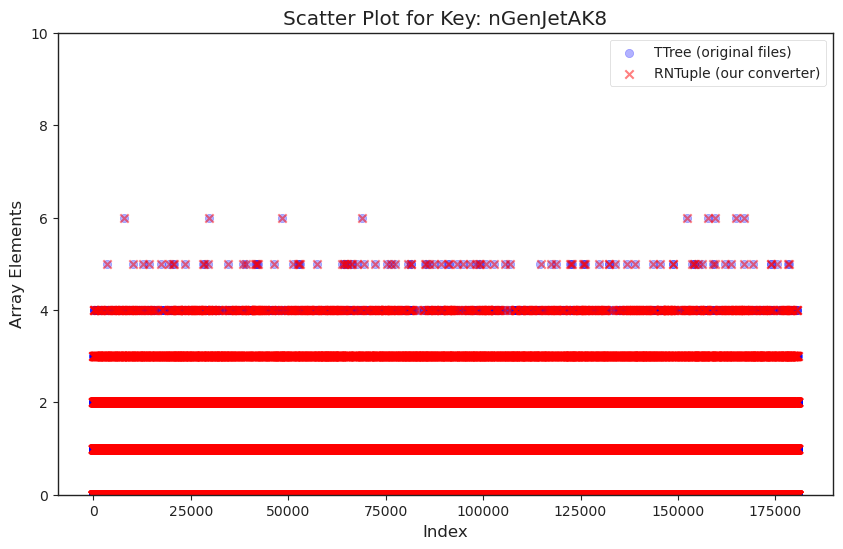

[uproot debug] key: column-727-cardinality, dtype_byte: 14
nGenPart TT: [52, 64, 46, 43, 45, 41, 62, 79, 53, ..., 59, 40, 39, 58, 63, 39, 63, 58, 77]  Len: 180738
nGenPart RN: [52, 64, 46, 43, 45, 41, 62, 79, 53, ..., 42, 47, 46, 69, 72, 42, 59, 40, 39]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


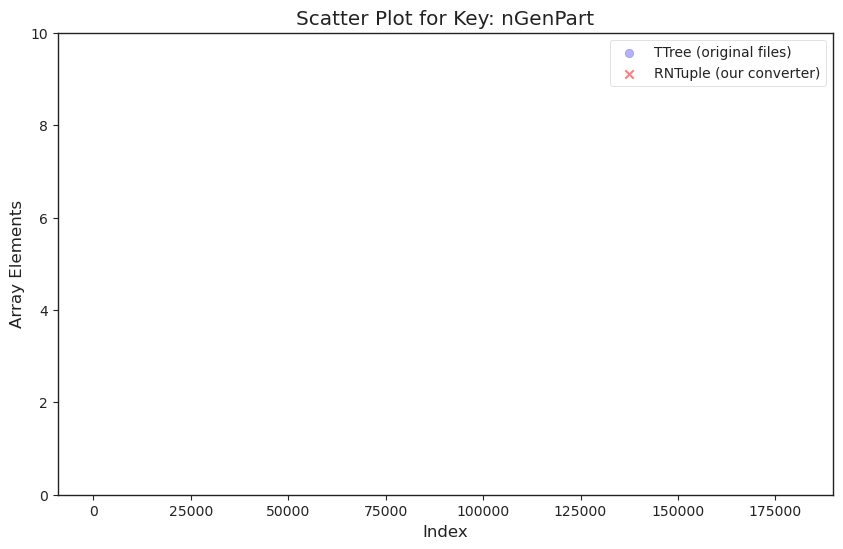

[uproot debug] key: column-736-cardinality, dtype_byte: 14
nGenVisTau TT: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]  Len: 180738
nGenVisTau RN: [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..., 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


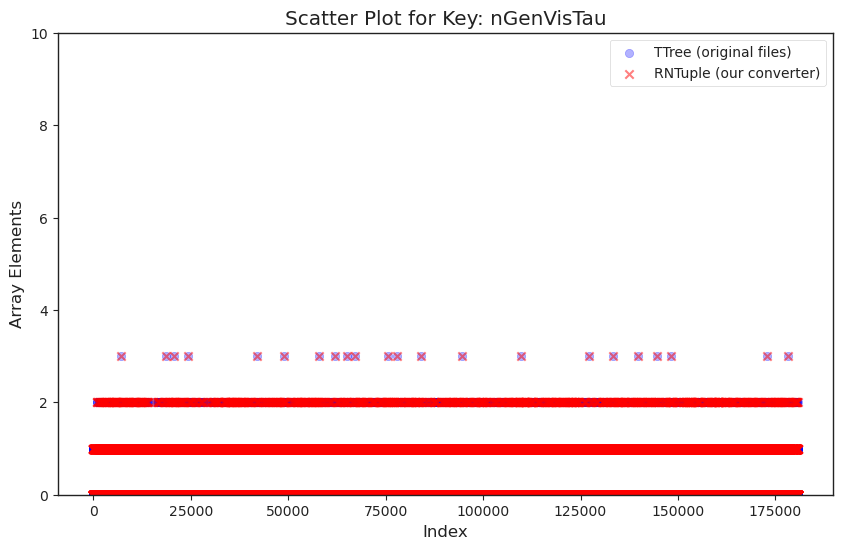

[uproot debug] key: column-744-cardinality, dtype_byte: 14
nJet TT: [12, 10, 7, 7, 12, 8, 7, 9, 9, 10, 10, ..., 16, 9, 13, 4, 4, 12, 8, 7, 5, 9, 9]  Len: 180738
nJet RN: [12, 10, 7, 7, 12, 8, 7, 9, 9, 10, 10, ..., 10, 6, 7, 8, 8, 10, 16, 9, 13, 4, 4]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


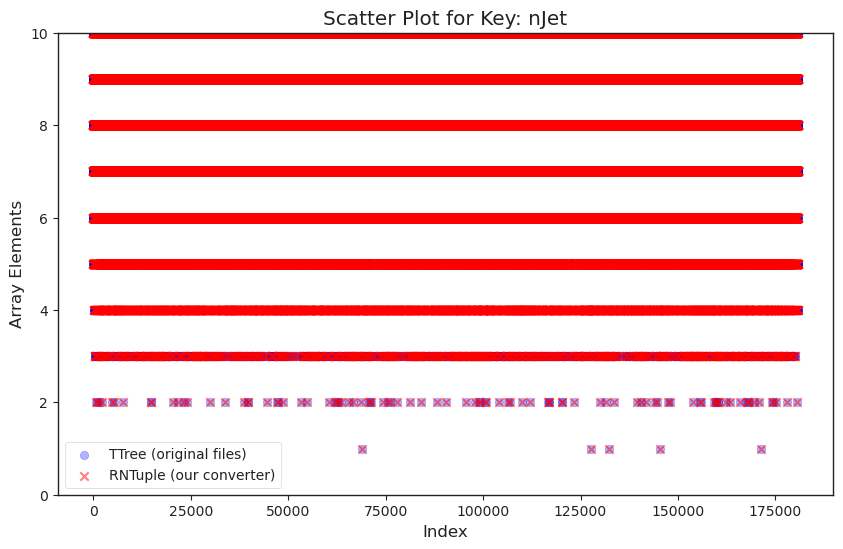

[uproot debug] key: column-785-cardinality, dtype_byte: 14
nLHEPart TT: [9, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, ..., 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8]  Len: 180738
nLHEPart RN: [9, 8, 8, 8, 8, 8, 8, 8, 9, 8, 8, 8, 8, ..., 8, 8, 9, 9, 8, 9, 8, 8, 8, 8, 8, 8]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


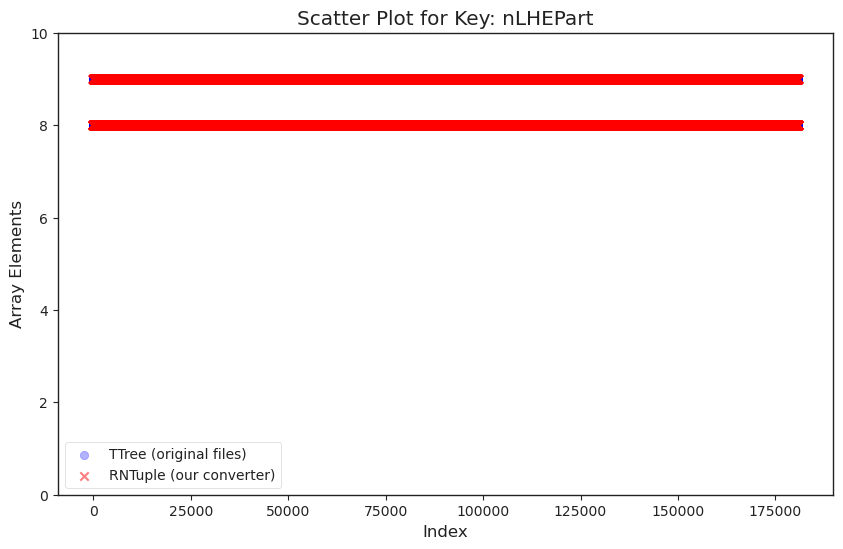

[uproot debug] key: column-794-cardinality, dtype_byte: 14
nLHEPdfWeight TT: [102, 102, 102, 102, 102, 102, 102, 102, ..., 102, 102, 102, 102, 102, 102, 102]  Len: 180738
nLHEPdfWeight RN: [102, 102, 102, 102, 102, 102, 102, 102, ..., 102, 102, 102, 102, 102, 102, 102]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


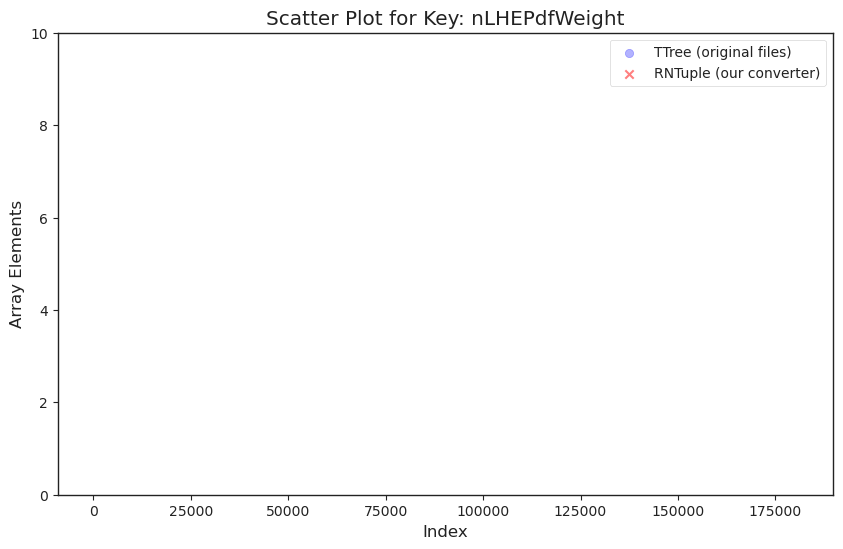

[uproot debug] key: column-798-cardinality, dtype_byte: 14
nLHEScaleWeight TT: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..., 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]  Len: 180738
nLHEScaleWeight RN: [9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, ..., 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9, 9]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


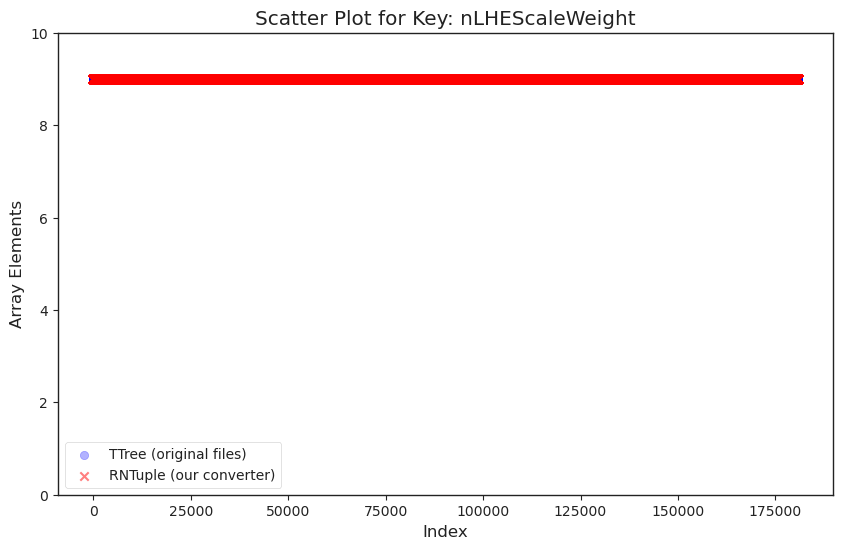

[uproot debug] key: column-800-cardinality, dtype_byte: 14
nMuon TT: [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..., 4, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0]  Len: 180738
nMuon RN: [1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..., 1, 0, 1, 1, 0, 1, 4, 0, 1, 1, 0, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


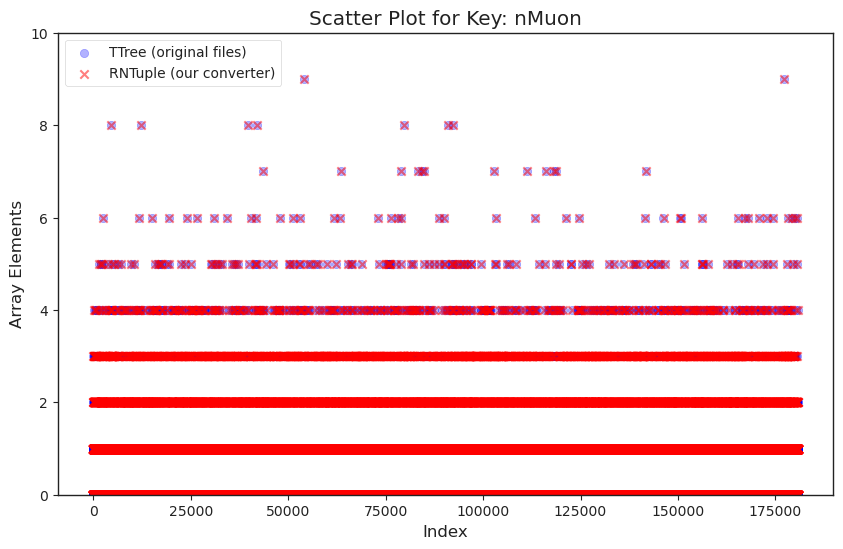

[uproot debug] key: column-858-cardinality, dtype_byte: 14
nOtherPV TT: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]  Len: 180738
nOtherPV RN: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ..., 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


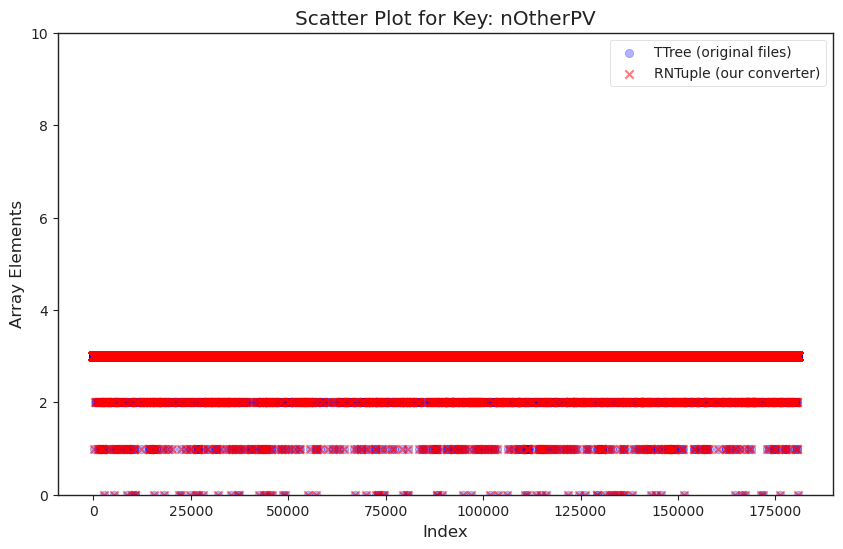

[uproot debug] key: column-862-cardinality, dtype_byte: 14
nPhoton TT: [1, 3, 3, 3, 4, 0, 1, 4, 2, 2, 3, 1, 2, ..., 4, 3, 3, 0, 1, 1, 4, 3, 0, 1, 1, 1]  Len: 180738
nPhoton RN: [1, 3, 3, 3, 4, 0, 1, 4, 2, 2, 3, 1, 2, ..., 1, 1, 0, 2, 0, 0, 4, 3, 3, 0, 1, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


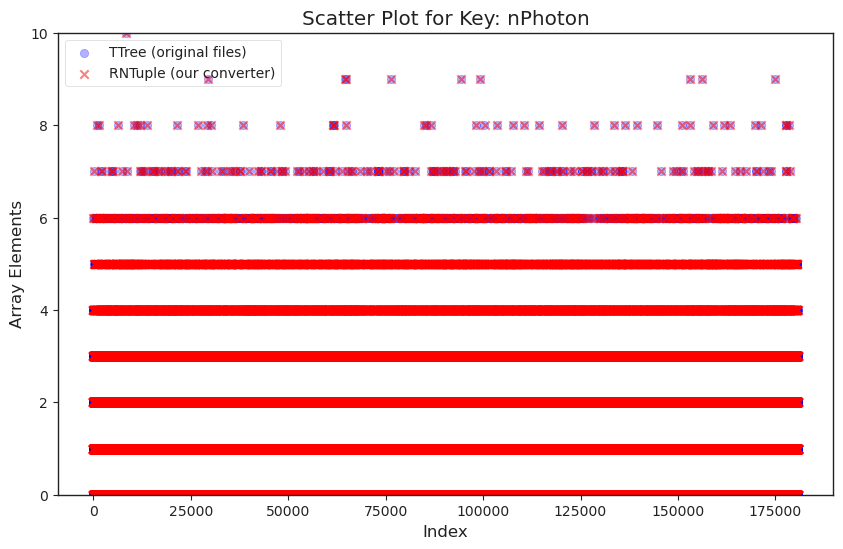

[uproot debug] key: column-860-cardinality, dtype_byte: 14
nPSWeight TT: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  Len: 180738
nPSWeight RN: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..., 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


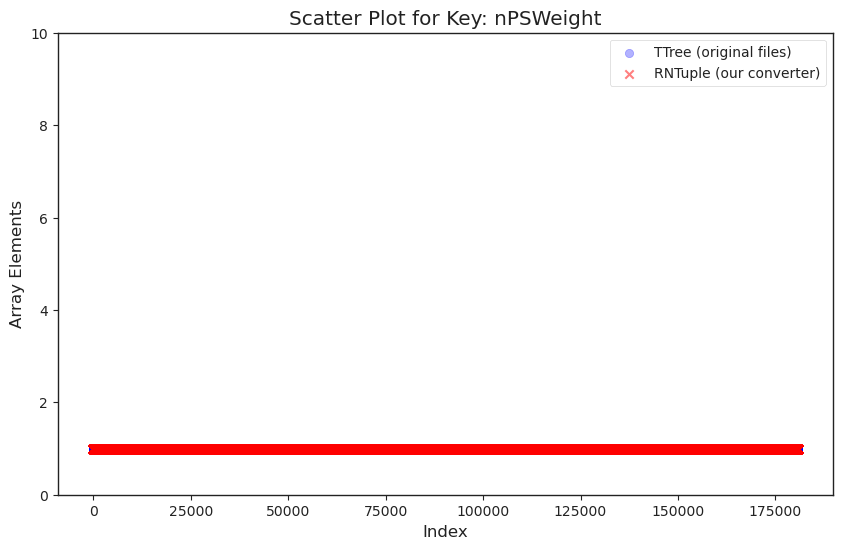

[uproot debug] key: column-909-cardinality, dtype_byte: 14
nSoftActivityJet TT: [6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, ..., 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]  Len: 180738
nSoftActivityJet RN: [6, 6, 6, 6, 2, 6, 6, 6, 6, 6, 6, 6, 6, ..., 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


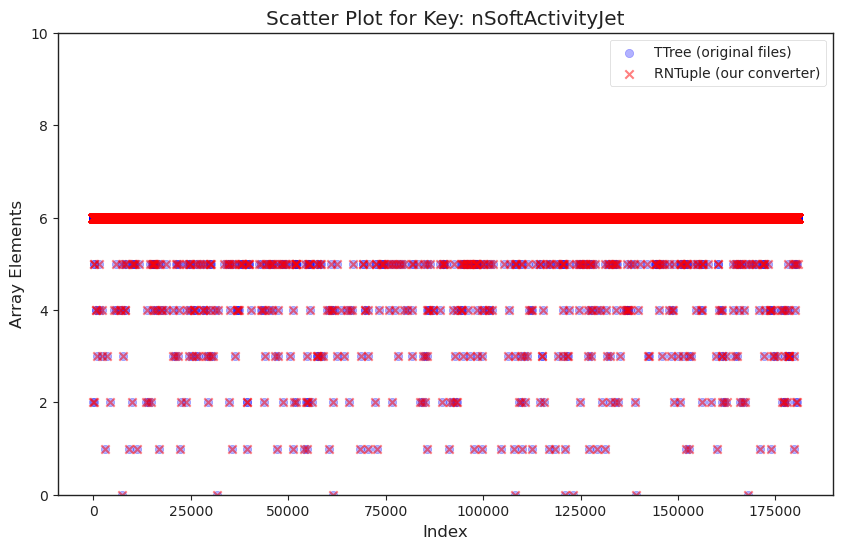

[uproot debug] key: column-892-cardinality, dtype_byte: 14
nSV TT: [0, 3, 1, 1, 0, 3, 1, 4, 1, 3, 2, 0, 3, ..., 4, 2, 3, 2, 2, 0, 6, 4, 1, 3, 2, 4]  Len: 180738
nSV RN: [0, 3, 1, 1, 0, 3, 1, 4, 1, 3, 2, 0, 3, ..., 1, 2, 2, 1, 0, 4, 4, 2, 3, 2, 2, 0]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


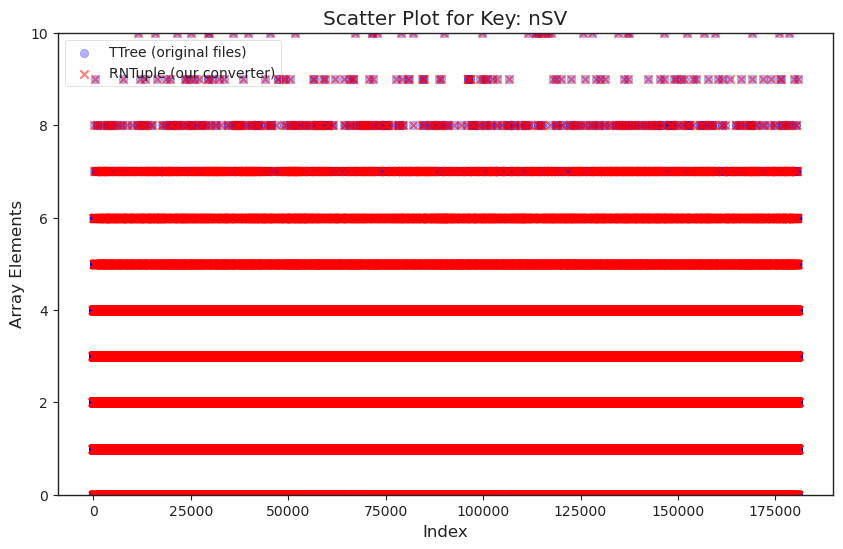

[uproot debug] key: column-913-cardinality, dtype_byte: 14
nTau TT: [0, 1, 1, 1, 4, 0, 0, 2, 1, 1, 1, 0, 1, ..., 0, 1, 0, 0, 1, 1, 2, 1, 1, 0, 0, 0]  Len: 180738
nTau RN: [0, 1, 1, 1, 4, 0, 0, 2, 1, 1, 1, 0, 1, ..., 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 180738


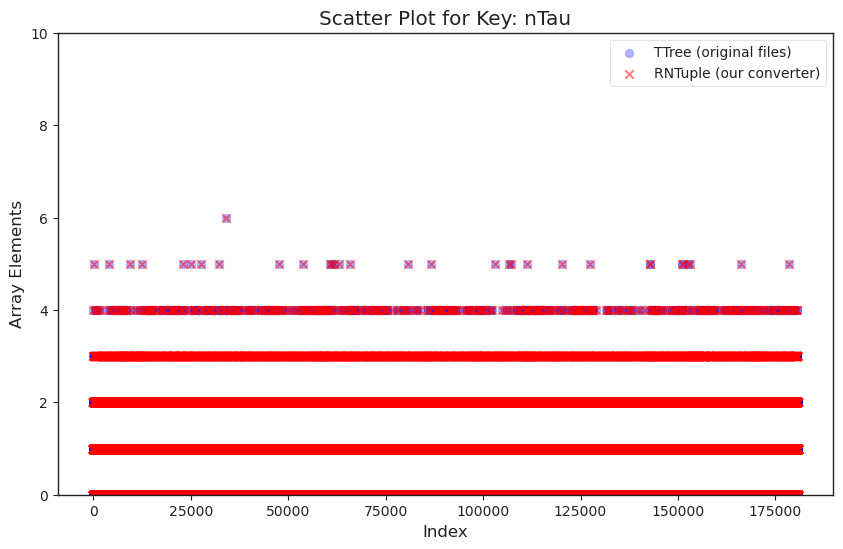

[uproot debug] key: column-892, dtype_byte: 14
[uproot debug] key: column-897, dtype_byte: 17
SV_pAngle TT: [[], [3.12, 3.11, 3.13], [3.13], ..., [3.11, 3.13], [3.12, 3.05, 3.13, 2.9]]  Len: 180738
SV_pAngle RN: [[], [3.12, 3.11, 3.13], [3.13], ..., [3.11, 3.13], [3.12, 3.05, 3.13, 2.9]]  Len: 180738
____________________________________________________________________________________________________________________
Len of rn after ravel: 411547


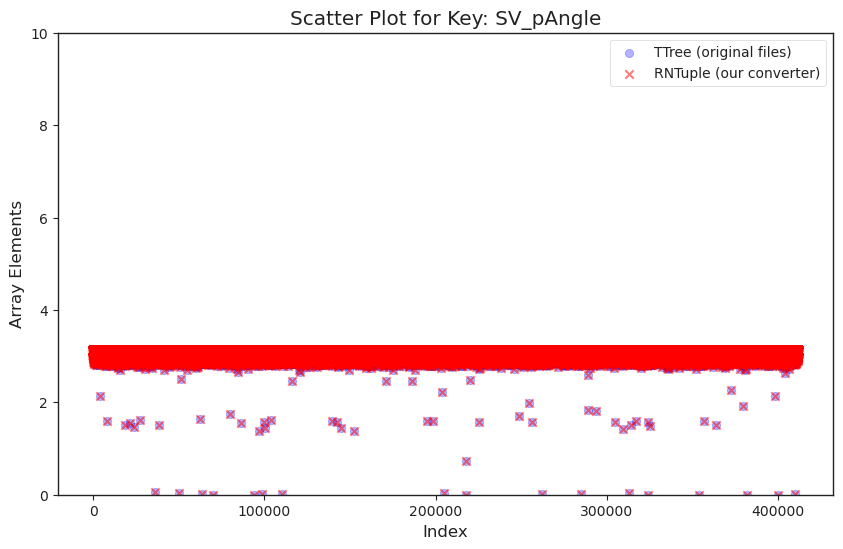

Finished cell


In [8]:
# Keys with mismatching arrays between TT and RN:
keys = ["HTXS_Higgs_y",
"nCorrT1METJet",
"nElectron",
"nFatJet",
"nFsrPhoton",
"nGenDressedLepton",
"nGenIsolatedPhoton",
"nGenJet",
"nGenJetAK8",
"nGenPart",
"nGenVisTau",
"nJet",
"nLHEPart",
"nLHEPdfWeight",
"nLHEScaleWeight",
"nMuon",
"nOtherPV",
"nPhoton",
"nPSWeight",
"nSoftActivityJet",
"nSV",
"nTau",
"SV_pAngle"]
for key in keys:
    arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
    arr_rn = events_rn.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]

    print(f"{key} TT:", arr_tt, f" Len: {len(arr_tt)}")
    print(f"{key} RN:", arr_rn, f" Len: {len(arr_rn)}")
    print(f"____________________________________________________________________________________________________________________")
# for key in events_rn.keys(): # all keys
#     # arr_tt = events_tt.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
#     arr_rn = events_rn.arrays(filter_name=[key], entry_start=strt, entry_stop=end)[key]
#     print(f"____________________________________________________________________________________________________________________")

    


print("Finished cell")



In [9]:
# # Test times for each function:

# import timeit

# # Define the operations as functions
# def array_1():
#     print(events_list[0].arrays(["Electron_pt"])["Electron_pt"])

# def array_1_direct():
#     print(events_list[0]["Electron_pt"].array())

# def array_2():
#     print(events_list[1].arrays(["Electron_pt"])["Electron_pt"])

# def array_2_direct():
#     print(events_list[1]["Electron_pt"].array())

# def array_3():
#     print(events_list[2].arrays(["Electron_pt"])["Electron_pt"])

# def array_3_direct():
#     print(events_list[2]["Electron_pt"].array())

# # Time the operations
# time_1 = timeit.timeit(array_1, number=1)
# print("Time for events1.arrays(['Electron_pt'])['Electron_pt']: ", time_1)
# time_1_direct = timeit.timeit(array_1_direct, number=1)
# print("Time for events1['Electron_pt'].array(): ", time_1_direct)

# print("*****")

# time_2 = timeit.timeit(array_2, number=1)
# print("Time for events2.arrays(['Electron_pt'])['Electron_pt']: ", time_2)
# time_2_direct = timeit.timeit(array_2_direct, number=1)
# print("Time for events2['Electron_pt'].array(): ", time_2_direct)

# print("*****")

# time_3 = timeit.timeit(array_3, number=1)
# print("Time for events3.arrays(['Electron_pt'])['Electron_pt']: ", time_3)
# time_3_direct = timeit.timeit(array_3_direct, number=1)
# print("Time for events3['Electron_pt'].array(): ", time_3_direct)








In [10]:
# create the task graph to build a histogram
print("Calculating trijet mass...")
reconstructed_top_mass = calculate_trijet_mass(events_list[0])
print("hist_reco_mtop...")
hist_reco_mtop = hist.dask.Hist.new.Reg(16, 0, 375, label="$m_{bjj}$").Double().fill(reconstructed_top_mass)
print("Finished cell")

Calculating trijet mass...


AttributeError: 'Model_TTree_v20' object has no attribute 'Electron'

and then once we're ready we can execute the task graph with `.compute()` to get our visualization

In [ ]:
# perform computation and visualize
artists = hist_reco_mtop.compute().plot()

In [ ]:
# and annotate the visualization
fig_dir = Path.cwd() / "figures"
fig_dir.mkdir(parents=True, exist_ok=True)

ax = artists[0].stairs.axes
fig = ax.get_figure()
ax.vlines(175, 0, 10000, colors=["grey"], linestyle="dotted")
ax.text(180, 150, "$m_{t} = 175$ GeV")
ax.set_xlim([0, 375])
ax.set_ylim([0, 8000])

fig.savefig(fig_dir / "trijet_mass.png", dpi=300)
fig

This all matches the (non-Dask) versions of the plots from last summer — see the notebook linked above. Not surprising, but reassuring!

### Time for coffea

We'll first write the functions to compute the observable and do the histogramming using `awkward-dask` and `hist.dask` again

In [ ]:
B_TAG_THRESHOLD = 0.5

# perform object selection
def object_selection(events):
    elecs = events.Electron
    muons = events.Muon
    jets = events.Jet

    electron_reqs = (elecs.pt > 30) & (np.abs(elecs.eta) < 2.1) & (elecs.cutBased == 4) & (elecs.sip3d < 4)
    muon_reqs = ((muons.pt > 30) & (np.abs(muons.eta) < 2.1) & (muons.tightId) & (muons.sip3d < 4) &
                 (muons.pfRelIso04_all < 0.15))
    jet_reqs = (jets.pt > 30) & (np.abs(jets.eta) < 2.4) & (jets.isTightLeptonVeto)

    # Only keep objects that pass our requirements
    elecs = elecs[electron_reqs]
    muons = muons[muon_reqs]
    jets = jets[jet_reqs]

    return elecs, muons, jets


# event selection for 4j1b and 4j2b
def region_selection(elecs, muons, jets):
    ######### Store boolean masks with PackedSelection ##########
    selections = PackedSelection(dtype='uint64')
    # Basic selection criteria
    selections.add("exactly_1l", (ak.num(elecs) + ak.num(muons)) == 1)
    selections.add("atleast_4j", ak.num(jets) >= 4)
    selections.add("exactly_1b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) == 1)
    selections.add("atleast_2b", ak.sum(jets.btagCSVV2 > B_TAG_THRESHOLD, axis=1) >= 2)
    # Complex selection criteria
    selections.add("4j1b", selections.all("exactly_1l", "atleast_4j", "exactly_1b"))
    selections.add("4j2b", selections.all("exactly_1l", "atleast_4j", "atleast_2b"))

    return selections.all("4j1b"), selections.all("4j2b")


# observable calculation for 4j2b
def calculate_m_reco_top(jets):
    # reconstruct hadronic top as bjj system with largest pT
    trijet = ak.combinations(jets, 3, fields=["j1", "j2", "j3"])  # trijet candidates
    trijet["p4"] = trijet.j1 + trijet.j2 + trijet.j3  # four-momentum of tri-jet system
    trijet["max_btag"] = np.maximum(trijet.j1.btagCSVV2,
                                    np.maximum(trijet.j2.btagCSVV2, trijet.j3.btagCSVV2))
    trijet = trijet[trijet.max_btag > B_TAG_THRESHOLD]  # at least one-btag in candidates
    # pick trijet candidate with largest pT and calculate mass of system
    trijet_mass = trijet["p4"][ak.argmax(trijet.p4.pt, axis=1, keepdims=True)].mass
    observable = ak.flatten(trijet_mass)

    return observable


# create histograms with observables
def create_histograms(events):
    hist_4j1b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="HT", label=r"$H_T$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    hist_4j2b = (
        hist.dask.Hist.new.Reg(25, 50, 550, name="m_reco_top", label=r"$m_{bjj}$ [GeV]")
        .StrCat([], name="process", label="Process", growth=True)
        .StrCat([], name="variation", label="Systematic variation", growth=True)
        .Weight()
    )

    process = events.metadata["process"]  # "ttbar" etc.
    variation = events.metadata["variation"]  # "nominal" etc.
    process_label = events.metadata["process_label"]  # nicer LaTeX labels

    # normalization for MC
    x_sec = events.metadata["xsec"]
    nevts_total = events.metadata["nevts"]
    lumi = 3378 # /pb
    if process != "data":
        xsec_weight = x_sec * lumi / nevts_total
    else:
        xsec_weight = 1

    elecs, muons, jets = object_selection(events)

    # region selection
    selection_4j1b, selection_4j2b = region_selection(elecs, muons, jets)

    # 4j1b: HT
    observable_4j1b = ak.sum(jets[selection_4j1b].pt, axis=-1)
    hist_4j1b.fill(observable_4j1b, weight=xsec_weight, process=process_label, variation=variation)

    # 4j2b: m_reco_top
    observable_4j2b = calculate_m_reco_top(jets[selection_4j2b])
    hist_4j2b.fill(observable_4j2b, weight=xsec_weight, process=process_label, variation=variation)

    return {"4j1b": hist_4j1b, "4j2b": hist_4j2b}

and prepare the fileset we need

In [ ]:
# fileset preparation
N_FILES_MAX_PER_SAMPLE = 1
# compared to coffea 0.7: list of file paths becomes list of dicts (path: trename)
fileset = utils.file_input.construct_fileset(N_FILES_MAX_PER_SAMPLE)

# fileset = {"ttbar__nominal": fileset["ttbar__nominal"]}  # to only process nominal ttbar
# fileset

Now we can start using `coffea` with its Dask capabilities. One of the things we need to do is to build the full task graph, which requires looping over all the sample variations (`samples`)

In [ ]:
%%time
# pre-process
samples, _ = dataset_tools.preprocess(fileset, step_size=250_000)

# workaround for https://github.com/CoffeaTeam/coffea/issues/1050 (metadata gets dropped, already fixed)
for k, v in samples.items():
    v["metadata"] = fileset[k]["metadata"]

In [ ]:
%%time
# create the task graph
tasks = dataset_tools.apply_to_fileset(create_histograms, samples, uproot_options={"allow_read_errors_with_report": True})

and then we can finally execute the full task graph with Dask

In [ ]:
%%time
# execute
((out, report),) = dask.compute(tasks)  # feels strange that this is a tuple-of-tuple

print(f"total time spent in uproot reading data (or some related metric?): {ak.sum([v['duration'] for v in report.values()]):.2f} s")

To visualize the results, we need to first stack the serperate histograms that were computed individually

In [ ]:
# stack all the histograms together (we processed each sample separately)
full_histogram_4j1b = sum([v["4j1b"] for v in out.values()])
full_histogram_4j2b = sum([v["4j2b"] for v in out.values()])

In [ ]:
artists = full_histogram_4j1b[120j::hist.rebin(2), :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, 1 b-tag");

fig.savefig(fig_dir / "coffea_4j_1b.png", dpi=300)

In [ ]:
artists = full_histogram_4j2b[:, :, "nominal"].stack("process")[::-1].plot(
    stack=True, histtype="fill", linewidth=1,edgecolor="grey"
)

ax = artists[0].stairs.axes
fig = ax.get_figure()

ax.legend(frameon=False)
ax.set_title(">= 4 jets, >= 2 b-tags");

fig.savefig(fig_dir / "coffea_4j_2b.png", dpi=300)

This is a plot you can compare to the one in the full AGC notebook — you'll notice they look the same. Success!

If we now investigate the task graph for the nominal $t\bar{t}$ sample in the optimzied view, which hides from us some of the complexity of the graph we created.

In [ ]:
tasks[0]["ttbar__nominal"]["4j2b"].visualize(optimize_graph=True)

In [ ]:
# "100 layers is a large task graph" on IRIS-HEP Slack, 100 layers happen quickly!
for region in ["4j1b", "4j2b"]:
    for process, task in tasks[0].items():
        print(f"{process:>30} {region} {len(task[region].dask.layers)}")

In [ ]:
# columns getting read for a given task
dak.necessary_columns(tasks[0]["ttbar__nominal"]["4j2b"])